In [4]:
import os
import pickle
import random
import copy
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.cluster import KMeans

## **Gym Environment**

In [5]:
DEFAULT_FIELD_PARAMS = [0, 0, 1.0]     # Vx, Vy, K
DEFAULT_ENV_PARAMS = [1.0, 1.0, 0.1]  # dx, dy, dt

# ---------------------------------------------------------------
# SPATIAL-TEMPORAL DIFFUSION FIELD
# ---------------------------------------------------------------

class SpatialTemporalDiffusionField():
    def __init__(self, pos=(50,50), map_size=100, field_size=40, field_max=25, n_timesteps=None, field_params=DEFAULT_FIELD_PARAMS, env_params=DEFAULT_ENV_PARAMS):
        # initialize field params
        self.dx, self.dy, self.dt = env_params
        self.vx, self.vy, self.k = field_params
        self.field_size, self.field_max, self.map_size = field_size, field_max, map_size
        self.snapshots = None
        # generate field
        field_hsize = field_size // 2
        self.gaussian_field = self.generate_multivariate_gaussian_field(N=field_size)
        self.field = np.zeros((map_size, map_size))
        self.padded_field = np.zeros((3*map_size, 3*map_size))
        x_start, x_end = map_size+pos[0]-field_hsize, map_size+pos[0]+field_hsize
        y_start, y_end = map_size+pos[1]-field_hsize, map_size+pos[1]+field_hsize
        self.padded_field[y_start:y_end, x_start:x_end]=self.gaussian_field
        self.field = self.padded_field[map_size:map_size*2,map_size:map_size*2]
        self.field = (self.field - np.min(self.field)) / (np.max(self.field)-np.min(self.field)) * self.field_max
        # generate snapshots
        if (n_timesteps is not None) and (n_timesteps > 0):
            self.snapshots = np.zeros((n_timesteps,map_size,map_size))
            self.snapshots[0] = self.field
            for i in range(1, n_timesteps):
                self.snapshots[i] = self.update_diffusion_field(self.snapshots[i-1])        
    
    def generate_multivariate_gaussian_field(self, N=40, mu=np.array([0.,0.]), sigma=np.array([[1.,0.],[0.,1.]])):
        X = np.linspace(-3.0, 3.0, N)
        Y = np.linspace(-3.0, 3.0, N)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:,:,0] = X
        pos[:,:,1] = Y
        n = mu.shape[0]
        sigma_det, sigma_inv = np.linalg.det(sigma), np.linalg.inv(sigma)
        N = np.sqrt((2*np.pi)**n * sigma_det)
        fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
        return np.exp(-fac / 2) / N
    
    def update_diffusion_field(self, field):
        updated_u = field.copy()
        u_k = field.copy()
        for i in range(1, field.shape[0] - 1):
            for j in range(1, field.shape[1] - 1):
                updated_u[j, i] = u_k[j, i] + self.k * (self.dt / self.dx ** 2) * \
                    ((u_k[j + 1, i] + u_k[j - 1, i] +
                      u_k[j, i + 1] + u_k[j, i - 1] - 4 * u_k[j, i])) + \
                    self.vx * (self.dt / self.dx) * ((u_k[j + 1, i] - u_k[j, i])) + self.vy * (self.dt / self.dy) * \
                    (u_k[j, i + 1] - u_k[j, i])
        return updated_u

In [6]:
# ---------------------------------------------------------------
# SPATIAL-TEMPORAL DIFFUSION ENVIRONMENT
# (consists of multiple diffusion fields)
# ---------------------------------------------------------------

class SpatialTemporalDiffusionEnvironment():
    def __init__(self, name, configs=[], env_params=DEFAULT_ENV_PARAMS, size=100, use_snapshots=True, n_timesteps=300):
        self.name = name
        self.field_size = size
        self.configs = configs
        self.dx, self.dy, self.dt = env_params
        self.n_timesteps = n_timesteps
        self.fields=[]
        self.timestep = 0
        for idx, config in enumerate(configs):
            self.fields.append(SpatialTemporalDiffusionField(pos=config['pos'], field_size=config['size'], field_params=config['params'], \
                    env_params=env_params, map_size=size, n_timesteps=n_timesteps if use_snapshots else None))
        self.set_timestep()
    
    def set_timestep(self, t=0):
        self.isolated_field_states = np.array([self.fields[i].snapshots[t] for i in range(len(self.fields))])
        self.env_field = np.sum(self.isolated_field_states, axis=0)
        self.timestep = t
        
    def step(self):
        if self.timestep < self.n_timesteps:
            self.set_timestep(self.timestep + 1)
        
    def get_single_field(self, idx=0):
        if (idx>=0) and (idx<len(self.fields)):
            return self.isolated_field_states[idx]
        else:
            return None
        
    def compute_gradient(self, pos=[50,50]):
        dz_dx = (self.env_field[pos[1], pos[0]+1] -
                 self.env_field[pos[1], pos[0]-1]) / (2 * self.dx)
        dz_dy = (self.env_field[pos[1]+1, pos[0]] -
                 self.env_field[pos[1]-1, pos[0]]) / (2 * self.dy)
        return np.array([dz_dx, dz_dy])
    
    def get_concentration(self, pos=[50,50]):
        return self.env_field[pos[1],pos[0]]

In [259]:
# ---------------------------------------------------------------
# SPATIAL-TEMPORAL DIFFUSION FIELD GYM WRAPPER
# ---------------------------------------------------------------

ACTION_MAP = {0:"left",1:"right",2:"up",3:"down",4:"stay",5:"up-left",6:"up-right",7:"down-left",8:"down-right"}
ACTIONS = ["left", "right", "up", "down", "stay", "up-left", "up-right", "down-left", "down-right"]
ACTION_OFFSET = np.array([[-1,0],[1,0],[0,-1],[0,1],[0,0],[-1,-1],[1,-1],[-1,1],[1,1]])
# DEFAULT_START_POSITIONS = [[50,20],[50,80],[20,50],[80,50],[25,25],[75,75]]

class SpatialTemporalDiffusionEnvGymWrapper(gym.Env):
    
    def __init__(self, envs=[], max_steps=299, vs_hsize=5, src_thresh=2, min_z_thresh=2, spawn_pos_range=[1.2,1.5], keep_env_on_reset=False):
        metadata = {'render.modes': ['human']}
        super(SpatialTemporalDiffusionEnvGymWrapper, self).__init__()
        
        self.envs = envs
        self.env = random.choice(envs)
        self.agent_field = AgentField(params=self.env.configs[0]['params'])
        self.keep_env_on_reset = keep_env_on_reset
        self.src_thresh = src_thresh
        self.min_z_thresh = min_z_thresh
        self.detected_srcs = []
        
        assert self.env.n_timesteps >= max_steps, f"max numsteps should not exceed max snapshots of this env"
                    
        self.max_steps = max_steps
        self.vs_hsize = vs_hsize
        self.spawn_pos_range = spawn_pos_range
        
        # Agent Field related params/variables
        self.agent_position = None
        self.num_steps = 0

        # Action Space
        self.action_space_map = ACTION_MAP
        self.actions = ACTIONS
        self.action_offsets = ACTION_OFFSET
        self.action_space = gym.spaces.Discrete(9)

        # Observation Space
        low = np.array([0.0, -100.0, -100.0])
        high = np.array([25.0, 100.0, 100.0])
        self.observation_space = gym.spaces.Box(low, high, dtype=np.float64)
        
    def step(self, action_id):
        # Ensure action is a valid action and exists in Agent's action space
        assert self.action_space.contains(action_id), "Action %r (%s) is invalid!" % (action_id, type(action_id))        
        action = self.action_space_map[action_id]

        # Get the next state
        (hit_wall, next_position) = self.get_next_position(action_id)
        if (hit_wall):
            # Stay at the same place if hitting boundary
            next_position = self.agent_position

        # Update field state
        self.env.step()
        
        # Update number of steps
        self.num_steps += 1

        # Update agent variables
        self.agent_position = next_position
        self.agent_field.update(self.env.env_field, self.agent_position)
        
        # Get concentration
        self.concentration = self.env.get_concentration(self.agent_position)
        self.gradients = self.env.compute_gradient(self.agent_position)        
        next_state = [self.concentration, self.gradients[0], self.gradients[1]]        
        # Check for termination criteria
        done = self.num_steps >= self.max_steps
        reward = self.calculate_reward(next_position, self.gradients)

        # Get any observations
        observations = {"location": next_position}
        self.src_centers = self.get_src_centers()
        source_detected, detected_src_idx = self.source_detected(self.src_centers)
        if source_detected and (not np.isin(self.detected_srcs,detected_src_idx).any()):
            self.detected_srcs.append(detected_src_idx)
            observations["source_found"] = self.src_centers[detected_src_idx]
            observations["source_mask"] = (self.env.isolated_field_states[detected_src_idx] > self.min_z_thresh).astype(float)
        return (next_state, reward, done, observations)
    
    def get_src_centers(self):
        src_centers = []
        for field in self.env.isolated_field_states:
            center = np.flip(np.unravel_index(np.argmax(field), field.shape))
            src_centers.append(center)
        src_centers = np.minimum(np.maximum(np.array(src_centers), self.vs_hsize), self.env.field_size-self.vs_hsize)
        return src_centers
        
    def source_detected(self, src_centers):
        src_distance = np.linalg.norm(src_centers - self.agent_position, axis=1)
        if (src_distance<self.src_thresh).any():
            detected_src_idx = np.argmin(src_distance)
            return True, detected_src_idx
        else:
            return False, None
    
    def get_random_start_position(self):
        in_range = (self.env.env_field>=self.spawn_pos_range[0]) & (self.env.env_field<=self.spawn_pos_range[1])
        return np.flip(random.choice(np.transpose(np.nonzero(in_range))))
    
    def reset(self, pos=None, env_id=None):
        if env_id is not None:
            self.env = self.envs[env_id]
        elif not self.keep_env_on_reset:
            self.env = random.choice(self.envs)
        assert self.env.n_timesteps >= self.max_steps, f"max numsteps should not exceed max snapshots of this env"
        self.num_steps = 0
        self.env.set_timestep()
        self.agent_position = pos if pos is not None else self.get_random_start_position()
        self.agent_field = AgentField(params=self.env.configs[0]['params'])
        self.agent_field.update(self.env.env_field, self.agent_position)
        self.concentration = self.env.get_concentration(self.agent_position)
        self.gradients = self.env.compute_gradient(self.agent_position)
        self.detected_srcs = []
        self.src_centers = []
        observations = {"location": self.agent_position}
        next_state = [self.concentration, self.gradients[0], self.gradients[1]]
        return next_state, observations

    def get_next_position(self, action_id):
        # Create a deepcopy of current state
        next_state = copy.deepcopy(self.agent_position)
        next_state = np.add(next_state, ACTION_OFFSET[action_id])

        # Check for collisions
        hit_wall = False
        if ((next_state[0] < (0 + self.vs_hsize) or next_state[0] >= (self.env.field_size - self.vs_hsize)) or
            ((next_state[1] < (0 + self.vs_hsize) or next_state[1] >= (self.env.field_size - self.vs_hsize)))):
            hit_wall = True

        return (hit_wall, next_state)
    
    def get_viewscope_state(self, next_state):
        vs_min_row, vs_max_row = next_state[0] - self.vs_hsize, next_state[0] + self.vs_hsize + 1
        vs_min_col, vs_max_col = next_state[1] - self.vs_hsize, next_state[1] + self.vs_hsize + 1
        vs_state = self.env.env_field[vs_min_col:vs_max_col, vs_min_row:vs_max_row]
        return vs_state

    def calculate_reward(self, next_state, gradients):
        reward_from_vs = 1e-2 * np.sum(self.get_viewscope_state(next_state))
        if reward_from_vs < 10:
            return reward_from_vs
        else:
            sum_sq_grad = (gradients[0] ** 2) + (gradients[1] ** 2)
            reward_from_grad = 20 * np.exp(-5 * sum_sq_grad)
            return reward_from_vs + reward_from_grad

In [258]:
class AgentField():
    def __init__(self, size=100, vs_hsize=5, params={}):
        self.size = size
        self.vs_hsize = vs_hsize
        self.load_params(params)
        self.vs_field = np.zeros((self.size,self.size))
        self.visited_field = np.zeros((self.size,self.size))
        self.curr_pos = None
        
    def load_params(self, params):
        self.dx, self.dy, self.vx, self.vy = DEFAULT_ENV_PARAMS[0], DEFAULT_ENV_PARAMS[1], params[0], params[1]
        self.dt, self.k = DEFAULT_ENV_PARAMS[2], params[2]

    def update(self, env_field, pos):
        min_x, max_x = pos[0] - self.vs_hsize, pos[0] + self.vs_hsize + 1
        min_y, max_y = pos[1] - self.vs_hsize, pos[1] + self.vs_hsize + 1
        self.curr_pos = pos
        self.vs_field[min_y:max_y, min_x:max_x] = env_field[min_y:max_y, min_x:max_x]
        self.visited_field[min_y:max_y, min_x:max_x] = 1
        self.update_viewscope_field()

    def update_viewscope_field(self):
        updated_u = self.vs_field.copy()
        u_k = self.vs_field.copy()
        for i in range(1, self.size - 1):
            for j in range(1, self.size - 1):
                updated_u[j, i] = u_k[j, i] + self.k * (self.dt / self.dx ** 2) * \
                    ((u_k[j + 1, i] + u_k[j - 1, i] +
                        u_k[j, i + 1] + u_k[j, i - 1] - 4 * u_k[j, i])) + \
                    self.vx * (self.dt / self.dx) * ((u_k[j + 1, i] - u_k[j, i])) + self.vy * (self.dt / self.dy) * \
                    (u_k[j, i + 1] - u_k[j, i])
        self.vs_field = updated_u

    def reset(self, pos=None):
        self.vs_field = np.zeros((self.size,self.size))
        self.visited_field = np.zeros((self.size,self.size))
        self.curr_pos = pos

## **Exploration Strategies**

### 1. Base Class

In [8]:
class BaseHandler():
    def __init__(self, field_size=100, position=(50,50)):
        pass
    def get_next_action(self, state, params):
        pass
    def reset(self, source_found=None, params={}):
        pass
    def get_action_by_dest(self, pos, dest):
        if (pos == dest).all():
            return 4, True
        dx = dest[0] - pos[0]
        dy = dest[1] - pos[1]
        steps = abs(dx) if abs(dx) > abs(dy) else abs(dy)
        offset = np.array([int(dx/steps), int(dy/steps)])
        action_id = np.where((ACTION_OFFSET==offset).all(1))[0][0]
        dest_reached = pos[0]+offset[0]==dest[0] and pos[1]+offset[1]==dest[1]
        return action_id, dest_reached
    def bounded_vec(self, raw_vec, field_size=100, padding=0):
        return np.array([max(min(raw_vec[0], field_size-padding-2), padding), max(min(raw_vec[1], field_size-padding-2), padding)])

### 2. Cluster-based Exploration

In [249]:
class ClusterBasedExplorationHandler(BaseHandler):
    def __init__(self, pos=[50,50], field_size=100, estimated_src_size=40, vs_hsize=5):
        self.pos = np.array(pos)
        self.field_size = field_size
        self.estimated_src_size = estimated_src_size
        self.field = np.zeros((self.field_size,self.field_size))
        self.field_mask = np.zeros((self.field_size,self.field_size))
        self.field_clusters = np.zeros((self.field_size,self.field_size))
        self.generate_clustered_field()
        self.nearest_centroid_idx = np.argmin(np.linalg.norm(self.centroids - self.pos, axis=1))
        self.target_centroid = np.round(self.centroids[self.nearest_centroid_idx])
        self.dest_reached = False
        
    def generate_clustered_field(self, k=6):
        self.indices = np.argwhere(self.field_mask == 0)
        self.kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(self.indices)
        self.field_clusters = np.zeros((self.field_size,self.field_size))
        for idx, fieldIdx in enumerate(self.indices):            
            self.field_clusters[fieldIdx[0],fieldIdx[1]] = self.kmeans.labels_[idx]+1
        self.centroids = self.kmeans.cluster_centers_[:,::-1]
        self.labels = np.array(list(range(len(self.centroids))))
        
    def get_next_action(self, state, params):
        self.pos = np.array(params['location'])
        if self.dest_reached:
            self.update_target_centroid()
        if self.target_centroid is None:
            return 4, False
        else:
            action_id, dest_reached = self.get_action_by_dest(self.pos, self.target_centroid)
            self.dest_reached = dest_reached
            return action_id, dest_reached
            
    def update_target_centroid(self):
        if len(self.centroids) > 1:
            self.field_mask[self.field_clusters==(self.labels[self.nearest_centroid_idx]+1)] = 1
            self.centroids = np.delete(self.centroids, self.nearest_centroid_idx, axis=0)
            self.labels =  np.delete(self.labels, self.nearest_centroid_idx, axis=0)
            if len(self.centroids) > 0:
                self.nearest_centroid_idx = np.argmin(np.linalg.norm(self.centroids - self.pos, axis=1))
                self.target_centroid = np.round(self.centroids[self.nearest_centroid_idx])
        else:
            self.nearest_centroid_idx = None
            self.target_centroid = None
                
    def reset(self, field_mask=None):
        if field_mask is not None:
            self.field_mask = ((self.field_mask + field_mask) > 0).astype(float)
            self.field_mask[self.field_clusters==(self.labels[self.nearest_centroid_idx]+1)] = 1
        unvisited_size = self.field_size**2 - np.count_nonzero(self.field_mask)
        estimated_k = unvisited_size / self.estimated_src_size**2
        if estimated_k > 0.25 and (self.field_mask == 0).any():
            self.generate_clustered_field(k=np.maximum(2, int(estimated_k)))
            self.nearest_centroid_idx = np.argmin(np.linalg.norm(self.centroids - self.pos, axis=1))
            self.target_centroid = np.round(self.centroids[self.nearest_centroid_idx])
        else:
            self.indices = np.argwhere(self.field_mask == 0)
            self.target_centroid = None

### 3. Lawn Mowing Approach

In [82]:
LAWNMOWING_START_PRESET = [[0,0],[0,1],[1,0],[1,1]]
LAWNMOWING_DIR_PRESET = [[1,1],[1,-1],[-1,1],[-1,-1]]
MAIN_AXIS, CROSS_AXIS = 0, 1

class LawnMowingExplorationHandler(BaseHandler):
    def __init__(self, field_size=100, vs_hsize=5):
        self.field_size = field_size
        self.vs_hsize = vs_hsize
        self.main_axis, self.cross_axis = MAIN_AXIS, CROSS_AXIS
        
    def reset(self, position=[50,50]):
        self.target_reached = False
        self.target = None        
        self.start_position, self.start_idx = self.get_start_position(position)
        self.main_direction, self.cross_direction = LAWNMOWING_DIR_PRESET[self.start_idx][0], LAWNMOWING_DIR_PRESET[self.start_idx][1]
        self.is_main_direction = True
        self.start_position_visited = False
        
    def get_start_position(self, position):
        curr_position = np.array(position)
        start_positions = np.array(LAWNMOWING_START_PRESET) * self.field_size
        distances = np.linalg.norm(start_positions - curr_position)
        nearest_idx = np.argmin(distances)
        return self.bounded_vec(start_positions[nearest_idx], field_size=self.field_size, padding=self.vs_hsize), nearest_idx
        
    def get_next_action(self, position=[50,50]):
        self.pos = np.array(position)
        if (self.target is None) or self.dest_reached:            
            self.target = self.get_target_position(position)
        action_id, self.dest_reached = self.get_action_by_dest(self.pos, self.target)
        return action_id, self.dest_reached
                
    def get_target_position(self, position):
        self.start_position_visited = self.start_position_visited or tuple(position) == tuple(self.start_position)
        if not self.start_position_visited:
            return self.start_position
        else:
            target = np.array(position)
            if self.is_main_direction:
                target[self.main_axis] += self.main_direction * self.field_size
                self.main_direction = -self.main_direction # main direction is toogled after being used
                self.is_main_direction = False
            else:
                target[self.cross_axis] += self.cross_direction * self.half_scope_size * 2
                self.is_main_direction = True
            target = self.bounded_vec(target, field_size=self.field_size, padding=self.vs_hsize)
            return target

### 4. Random Walking Approach

In [83]:
class RandomExplorationHandler(BaseHandler):
    def get_next_action(self, position):
        return np.random.randint(0,9), False

## **Dummy Source-heading Component**

In [84]:
class GradientSourceHeadingHandler(BaseHandler):
    def __init__(self, field_size=100, vs_hsize=5, k=2):
        self.k = k
        self.field_size = field_size
        self.vs_hsize = vs_hsize
    def get_next_action(self, state, params):
        assert state is not None, "no state available"
        grad_vec = np.array([state[1], state[2]])
        grad_vec_k = self.k * grad_vec / np.linalg.norm(grad_vec)
        position = np.array(params['location'])
        target_position = self.bounded_vec(position + grad_vec_k, field_size=self.field_size).round()
        action_id, dest_reached = self.get_action_by_dest(position, target_position)
        return action_id

## **Testing Cluster-based Exploration Agent**

In [263]:
def plot_env_subplot(env, agent, traj, ax, name, vs_hsize=5):
    import matplotlib.patches as patches
    ax.set_title(name)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.imshow(agent.vs_field)
    traj_r = [position[0] for position in traj]
    traj_c = [position[1] for position in traj]
    ax.plot(traj_r, traj_c, '.', color='black')
    ax.plot(traj[0][0], traj[0][1], '*', color='red')
    view_scope_box = patches.Rectangle(
        (traj[-1][0] - vs_hsize,
         traj[-1][1] - vs_hsize), vs_hsize*2+1, vs_hsize*2+1,
        linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(view_scope_box)

3.5175
4.43875
1.218125
3.093125
1.079375
3.778125
0.0
4.626875
3.0275
4.2575
3.008125


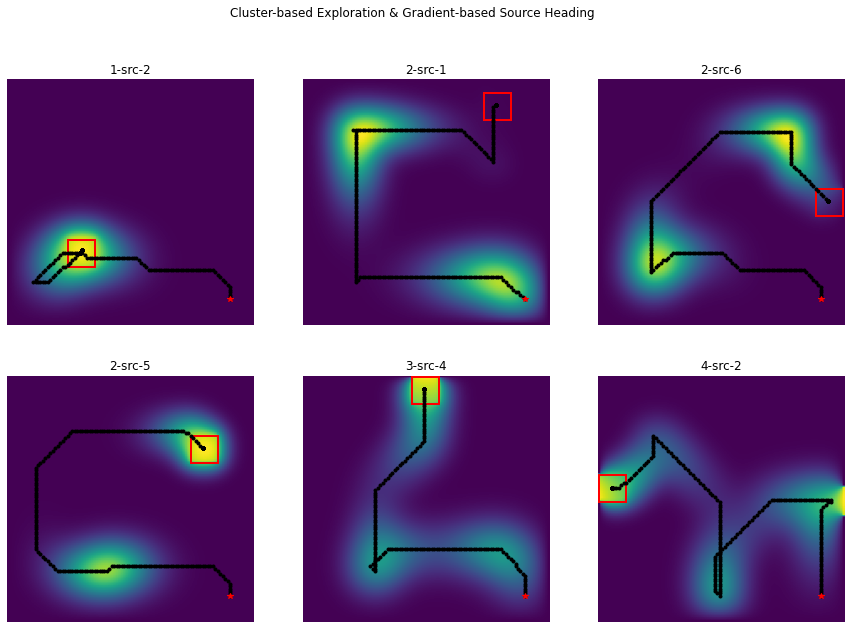

In [265]:
import pickle

selected_maps = ['1-src-2','2-src-1','2-src-6','2-src-5','3-src-4','4-src-2']
envs = []
for name in selected_maps:
    with open(f'./data/envs/{name}.dat', 'rb') as handle:
        envs.append(pickle.load(handle))

env_wrapper = SpatialTemporalDiffusionEnvGymWrapper(envs=envs)
INITIAL_POS = [90,90]
fig, axes = plt.subplots(len(selected_maps)//3, 3, figsize=(15, 10))
fig.suptitle('Cluster-based Exploration & Gradient-based Source Heading')
for idx, name in enumerate(selected_maps):
    state, obsr  = env_wrapper.reset(pos=INITIAL_POS, env_id=idx)
    steps = 0
    z_thresh = 2
    exploration_handler = ClusterBasedExplorationHandler(pos=INITIAL_POS)
    src_heading_handler = GradientSourceHeadingHandler()
    explore_mode = True
    new_target_reached = True
    traj = []
    src_found = 0
    while True:
        if explore_mode:
            action_id, dest_reached = exploration_handler.get_next_action(state, obsr)
            new_target_reached = new_target_reached or dest_reached 
            state, reward, done, obsr = env_wrapper.step(action_id)
            if state[0] > z_thresh and new_target_reached:
                explore_mode = False
        else:
            action_id = src_heading_handler.get_next_action(state, obsr)    
            state, reward, done, obsr = env_wrapper.step(action_id)
            if "source_found" in obsr.keys() and src_found<2:
                src_found += 1
                explore_mode = True
                new_target_reached = False
                exploration_handler.reset(field_mask=obsr["source_mask"])

        traj.append(obsr["location"])
        if done:
            plot_env_subplot(env_wrapper.env, env_wrapper.agent_field, traj, axes[idx//3,idx%3], name)
            # plt.imshow(env.agent_field.visited_field)
            break
        steps += 1 
